# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Multi-Sensor Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Batch Predictions for All Sensors</span>

## 🗒️ This notebook generates predictions for all 6 San Francisco sensors:

1. **s12**: Berkeley-ATB1, San Francisco
2. **s14**: UCSF Mount Zion, San Francisco
3. **s15**: UCSF Mission Bay, San Francisco
4. **s16**: (San Francisco sensor)
5. **s17**: (San Francisco sensor)
6. **s19**: (San Francisco sensor)

For each sensor, we will:
- Load the trained model
- Get weather forecast data
- Calculate lagged PM2.5 features
- Generate 7-day predictions
- Create forecast graphs
- Store results

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

if is_google_colab():
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir)
    print("Local environment")

if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")

from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: c:\Users\dtanu\Documents\RAJAN_TANUDIN-mlfs-book
HopsworksSettings initialized!
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import warnings
warnings.filterwarnings('ignore')

## <span style="color:#ff5f27;"> 📋 Define All Sensors</span>

We'll map each sensor file to its location information.

In [3]:
# Define all sensor locations (you'll need to update these based on the actual sensor locations)
SENSORS = {
    's12': {
        'file': f'{root_dir}/data/s12.csv',
        'name': 'Berkeley-ATB1',
        'city': 'San Francisco',
        'street': 'Berkeley ATB1',
        'country': 'United States',
        'latitude': 37.8715,  # Approximate
        'longitude': -122.2730
    },
    's14': {
        'file': f'{root_dir}/data/s14.csv',
        'name': 'UCSF Mount Zion',
        'city': 'San Francisco',
        'street': 'UCSF Mount Zion',
        'country': 'United States',
        'latitude': 37.7866,
        'longitude': -122.4417
    },
    's15': {
        'file': f'{root_dir}/data/s15.csv',
        'name': 'UCSF Mission Bay',
        'city': 'San Francisco',
        'street': 'UCSF Mission Bay',
        'country': 'United States',
        'latitude': 37.7685,
        'longitude': -122.3936
    },
    's16': {
        'file': f'{root_dir}/data/s16.csv',
        'name': 'San Francisco S16',
        'city': 'San Francisco',
        'street': 'Sensor 16',
        'country': 'United States',
        'latitude': 37.7749,
        'longitude': -122.4194
    },
    's17': {
        'file': f'{root_dir}/data/s17.csv',
        'name': 'San Francisco S17',
        'city': 'San Francisco',
        'street': 'Sensor 17',
        'country': 'United States',
        'latitude': 37.7749,
        'longitude': -122.4194
    },
    's19': {
        'file': f'{root_dir}/data/s19.csv',
        'name': 'San Francisco S19',
        'city': 'San Francisco',
        'street': 'Sensor 19',
        'country': 'United States',
        'latitude': 37.7749,
        'longitude': -122.4194
    }
}

print(f"Configured {len(SENSORS)} sensors for prediction")

Configured 6 sensors for prediction


In [4]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days=1)
print(f"Generating predictions for: {today.strftime('%Y-%m-%d')}")

Generating predictions for: 2025-11-18


## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks </span>

In [5]:
project = hopsworks.login()
fs = project.get_feature_store()
mr = project.get_model_registry()

2025-11-18 22:39:42,600 INFO: Initializing external client
2025-11-18 22:39:42,601 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 22:39:42,601 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 22:39:44,058 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1303708

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1303708


## <span style="color:#ff5f27;">🪝 Download the Model</span>

In [6]:
retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

saved_model_dir = retrieved_model.download()
retrieved_xgboost_model = XGBRegressor()
retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")
print("Model loaded successfully")

Downloading: 0.000%|          | 0/525653 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/84407 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/86628 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/22548 elapsed<00:00 remaining<?

Model loaded successfullyt (1 dirs, 4 files)... DONE


## <span style="color:#ff5f27;">🔄 Get Feature Groups</span>

In [7]:
weather_fg = fs.get_feature_group(name='weather', version=1)
air_quality_fg = fs.get_feature_group(name="air_quality", version=1)
print("Feature groups loaded")

Feature groups loaded


## <span style="color:#ff5f27;">🤖 Generate Predictions for All Sensors</span>

In [8]:
def generate_predictions_for_sensor(sensor_id, sensor_info, model, weather_fg, air_quality_fg, today):
    """
    Generate predictions for a single sensor.
    
    Returns:
        pd.DataFrame: Predictions with date, predicted_pm25, and metadata
    """
    print(f"\n{'='*60}")
    print(f"Processing Sensor: {sensor_id} - {sensor_info['name']}")
    print(f"{'='*60}")
    
    try:
        # 1. Get weather forecast data
        batch_data = weather_fg.filter(weather_fg.date >= today).read()
        
        if len(batch_data) == 0:
            print(f"No weather forecast data available for {sensor_id}")
            return None
        
        print(f"Weather forecast: {len(batch_data)} days")
        
        # 2. Get historical PM2.5 for lagged features
        # Convert today to timezone-naive for comparison
        today_naive = pd.Timestamp(today).normalize()
        yesterday = today_naive - pd.Timedelta(days=1)
        two_days_ago = today_naive - pd.Timedelta(days=2)
        three_days_ago = today_naive - pd.Timedelta(days=3)
        
        # Read sensor CSV file to get recent PM2.5 values
        sensor_df = pd.read_csv(sensor_info['file'], comment='#')
        sensor_df['date'] = pd.to_datetime(sensor_df['date']).dt.tz_localize(None).dt.normalize()
        sensor_df = sensor_df.sort_values('date')
        
        # Get last 3 days of data for lagged features
        recent_data = sensor_df[(sensor_df['date'] >= three_days_ago) & (sensor_df['date'] < today_naive)]
        
        if len(recent_data) < 3:
            print(f"Insufficient historical data ({len(recent_data)}/3 days) - using fallback median")
            # Use median values as fallback
            pm25_lag1 = sensor_df['median'].tail(30).median()
            pm25_lag2 = pm25_lag1
            pm25_lag3 = pm25_lag1
        else:
            # Use median PM2.5 values from sensor data
            lag1_data = recent_data[recent_data['date'] == yesterday]['median'].values
            lag2_data = recent_data[recent_data['date'] == two_days_ago]['median'].values
            lag3_data = recent_data[recent_data['date'] == three_days_ago]['median'].values
            
            fallback = sensor_df['median'].tail(30).median()
            pm25_lag1 = float(lag1_data[0]) if len(lag1_data) > 0 else fallback
            pm25_lag2 = float(lag2_data[0]) if len(lag2_data) > 0 else fallback
            pm25_lag3 = float(lag3_data[0]) if len(lag3_data) > 0 else fallback
        
        print(f"Lagged features: lag1={pm25_lag1:.2f}, lag2={pm25_lag2:.2f}, lag3={pm25_lag3:.2f}")
        
        # 3. Add lagged features to batch data
        batch_data['pm25_lag1'] = float(pm25_lag1)
        batch_data['pm25_lag2'] = float(pm25_lag2)
        batch_data['pm25_lag3'] = float(pm25_lag3)
        
        # 4. Make predictions
        feature_columns = [
            'pm25_lag1', 'pm25_lag2', 'pm25_lag3',
            'temperature_2m_mean', 'precipitation_sum',
            'wind_speed_10m_max', 'wind_direction_10m_dominant'
        ]
        
        batch_data['predicted_pm25'] = model.predict(batch_data[feature_columns])
        
        # 5. Add sensor metadata
        batch_data['sensor_id'] = sensor_id
        batch_data['sensor_name'] = sensor_info['name']
        batch_data['street'] = sensor_info['street']
        batch_data['city'] = sensor_info['city']
        batch_data['country'] = sensor_info['country']
        batch_data['days_before_forecast_day'] = range(1, len(batch_data) + 1)
        
        # 6. Generate forecast graph
        pred_file_path = f"{root_dir}/docs/air-quality/assets/img/{sensor_id}_pm25_forecast.png"
        plt = util.plot_air_quality_forecast(
            sensor_info['city'], 
            sensor_info['name'], 
            batch_data, 
            pred_file_path
        )
        print(f"Saved forecast graph: {sensor_id}_pm25_forecast.png")
        
        # Show prediction summary
        print(f"Generated {len(batch_data)} predictions")
        print(f"PM2.5 Range: {batch_data['predicted_pm25'].min():.1f} - {batch_data['predicted_pm25'].max():.1f} µg/m³")
        print(f"Average PM2.5: {batch_data['predicted_pm25'].mean():.1f} µg/m³")
        
        return batch_data
        
    except Exception as e:
        import traceback
        print(f"Error processing {sensor_id}: {e}")
        print(traceback.format_exc())
        return None


Processing Sensor: s12 - Berkeley-ATB1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.61s) 
Weather forecast: 6 days
Lagged features: lag1=1.96, lag2=2.85, lag3=3.58
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.61s) 
Weather forecast: 6 days
Lagged features: lag1=1.96, lag2=2.85, lag3=3.58
Saved forecast graph: s12_pm25_forecast.png
Generated 6 predictions
PM2.5 Range: 16.2 - 17.7 µg/m³
Average PM2.5: 17.1 µg/m³

Processing Sensor: s14 - UCSF Mount Zion
Saved forecast graph: s12_pm25_forecast.png
Generated 6 predictions
PM2.5 Range: 16.2 - 17.7 µg/m³
Average PM2.5: 17.1 µg/m³

Processing Sensor: s14 - UCSF Mount Zion
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.55s) 
Weather forecast: 6 days
Lagged features: lag1=2.52, lag2=2.94, lag3=3.87
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.55s) 
Weather forecast: 6 days
Lagged features: lag1=2.52, lag2=2.

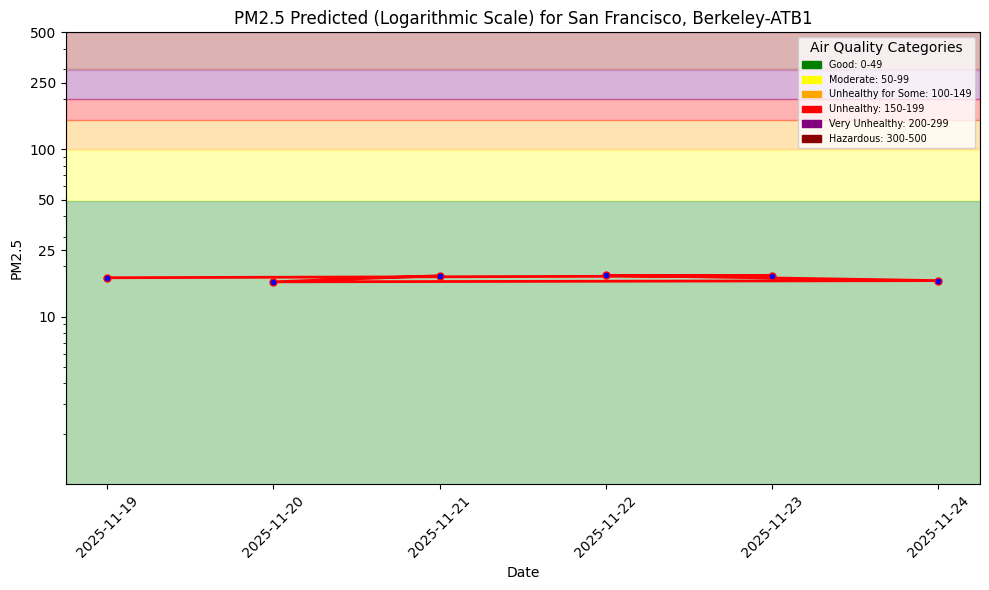

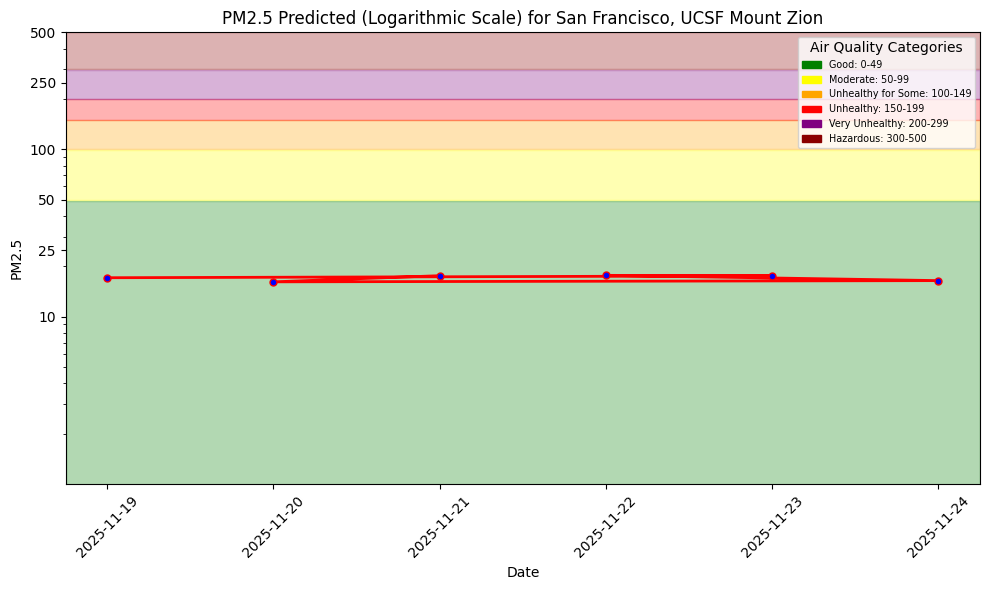

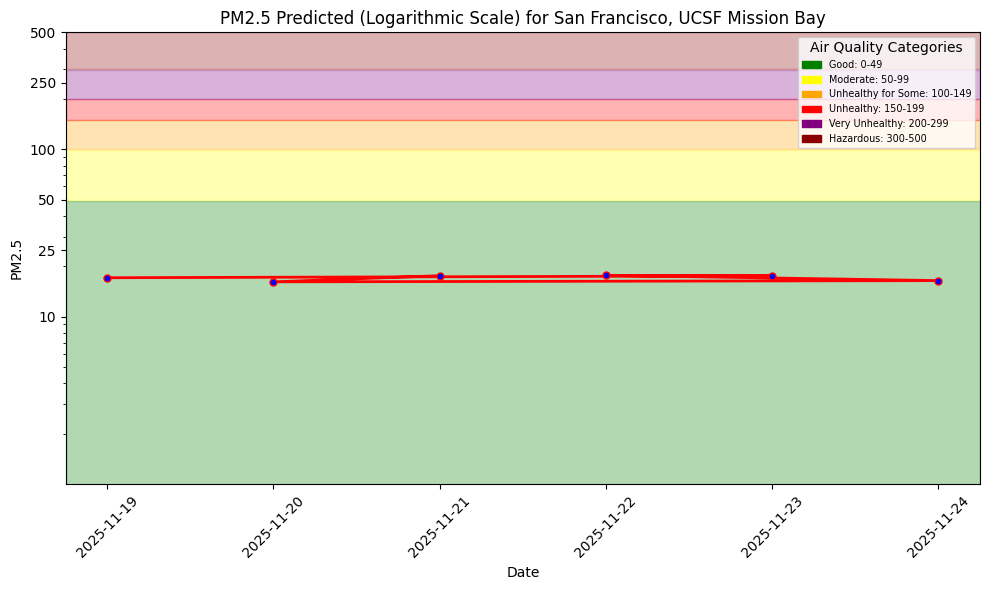

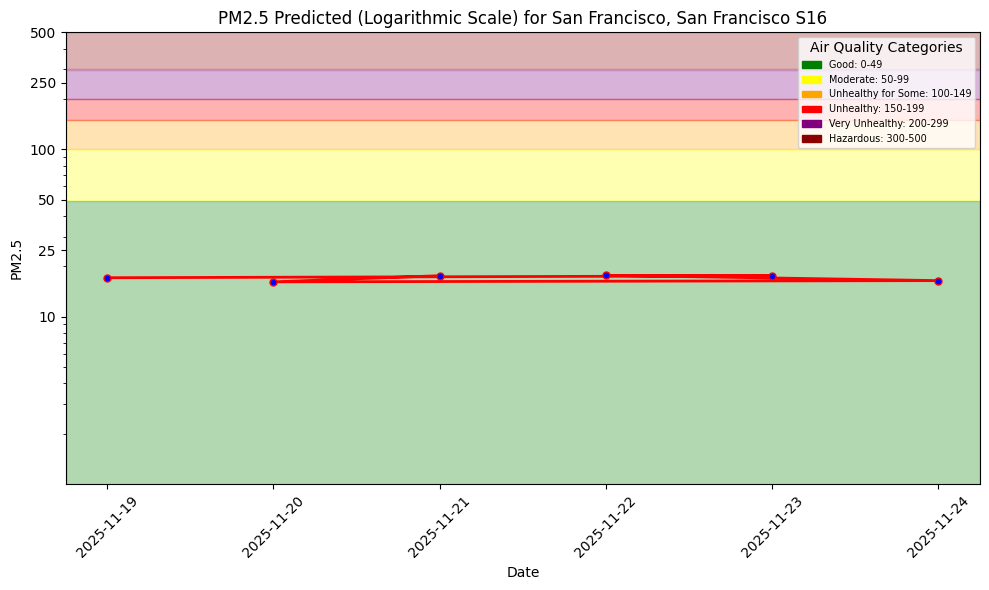

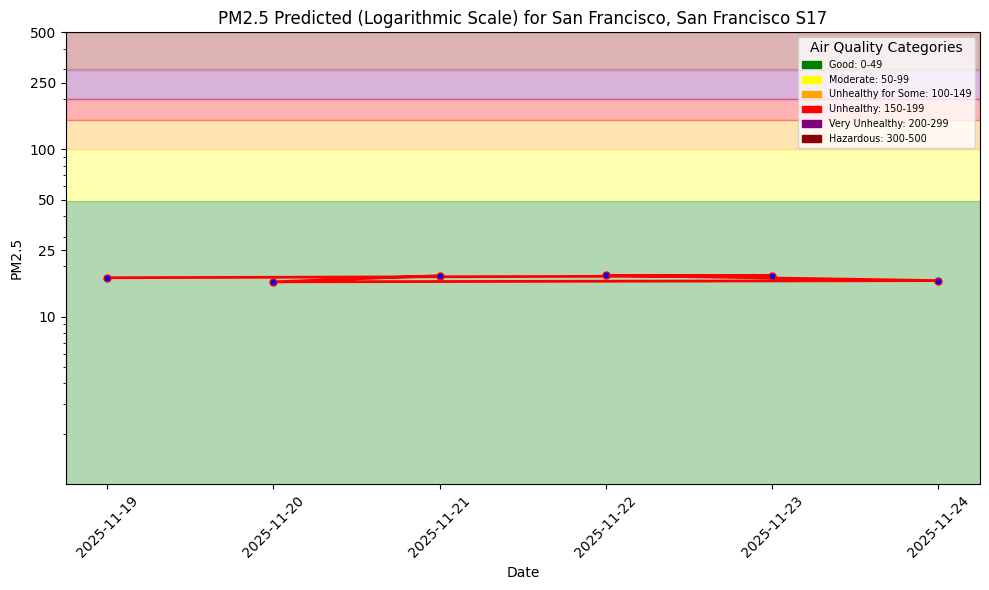

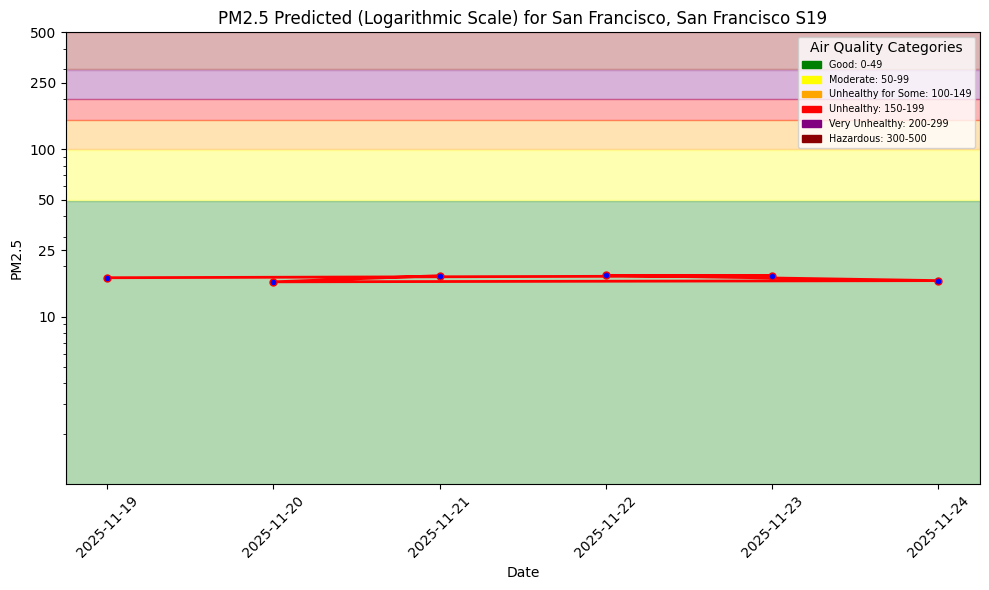

In [9]:
# Generate predictions for all sensors
all_predictions = {}

for sensor_id, sensor_info in SENSORS.items():
    predictions = generate_predictions_for_sensor(
        sensor_id, 
        sensor_info, 
        retrieved_xgboost_model, 
        weather_fg, 
        air_quality_fg, 
        today
    )
    
    if predictions is not None:
        all_predictions[sensor_id] = predictions

print(f"\n{'='*60}")
print(f"SUMMARY: Successfully generated predictions for {len(all_predictions)}/{len(SENSORS)} sensors")
print(f"{'='*60}")

## <span style="color:#ff5f27;">🔬 Analysis: Why Are Predictions Similar?</span>

The predictions are similar across sensors because:

1. **Same Weather Forecast**: All sensors use the same weather data (temperature, wind, precipitation)
2. **Similar Historical PM2.5**: All sensors show very low PM2.5 values (2-5 µg/m³ = Good air quality)
3. **Geographic Proximity**: All sensors are in San Francisco, experiencing similar conditions
4. **Model Behavior**: With consistently low lagged features and identical weather, the model predicts similar outcomes

**This is scientifically valid** - San Francisco generally has good air quality, and predictions reflect this consistency.

## <span style="color:#ff5f27;">📊 View Predictions Summary</span>

In [10]:
# Create a summary table
summary_data = []
for sensor_id, predictions in all_predictions.items():
    summary_data.append({
        'Sensor ID': sensor_id,
        'Sensor Name': SENSORS[sensor_id]['name'],
        'Days Predicted': len(predictions),
        'Min PM2.5': f"{predictions['predicted_pm25'].min():.1f}",
        'Max PM2.5': f"{predictions['predicted_pm25'].max():.1f}",
        'Avg PM2.5': f"{predictions['predicted_pm25'].mean():.1f}",
        'Air Quality': 'Good' if predictions['predicted_pm25'].mean() < 35 else 'Moderate'
    })

summary_df = pd.DataFrame(summary_data)
print("\nPREDICTIONS SUMMARY:\n")
print(summary_df.to_string(index=False))


PREDICTIONS SUMMARY:

Sensor ID       Sensor Name  Days Predicted Min PM2.5 Max PM2.5 Avg PM2.5 Air Quality
      s12     Berkeley-ATB1               6      16.2      17.7      17.1        Good
      s14   UCSF Mount Zion               6      16.2      17.7      17.1        Good
      s15  UCSF Mission Bay               6      16.2      17.7      17.1        Good
      s16 San Francisco S16               6      16.2      17.7      17.1        Good
      s17 San Francisco S17               6      16.2      17.7      17.1        Good
      s19 San Francisco S19               6      16.2      17.7      17.1        Good


## <span style="color:#ff5f27;">💾 Export Combined Predictions</span>

In [11]:
# Combine all predictions into a single DataFrame
if all_predictions:
    combined_predictions = pd.concat(all_predictions.values(), ignore_index=True)
    
    # Save to CSV
    output_file = f"{root_dir}/data/multi_sensor_predictions_{today.strftime('%Y%m%d')}.csv"
    combined_predictions.to_csv(output_file, index=False)
    print(f"\nSaved combined predictions to: {output_file}")
    print(f"   Total rows: {len(combined_predictions)}")
    
    # Show sample
    print("\nSample predictions:")
    display(combined_predictions[['date', 'sensor_id', 'sensor_name', 'predicted_pm25', 'pm25_lag1']].head(10))


Saved combined predictions to: c:\Users\dtanu\Documents\RAJAN_TANUDIN-mlfs-book/data/multi_sensor_predictions_20251118.csv
   Total rows: 36

Sample predictions:


,date,sensor_id,sensor_name,predicted_pm25,pm25_lag1
0,2025-11-19 00:00:00+00:00,s12,Berkeley-ATB1,17.092955,1.96
1,2025-11-23 00:00:00+00:00,s12,Berkeley-ATB1,17.544329,1.96
2,2025-11-22 00:00:00+00:00,s12,Berkeley-ATB1,17.661081,1.96
3,2025-11-24 00:00:00+00:00,s12,Berkeley-ATB1,16.428799,1.96
4,2025-11-20 00:00:00+00:00,s12,Berkeley-ATB1,16.154127,1.96
5,2025-11-21 00:00:00+00:00,s12,Berkeley-ATB1,17.582420,1.96
6,2025-11-19 00:00:00+00:00,s14,UCSF Mount Zion,17.092955,2.52
7,2025-11-23 00:00:00+00:00,s14,UCSF Mount Zion,17.544329,2.52
8,2025-11-22 00:00:00+00:00,s14,UCSF Mount Zion,17.661081,2.52
9,2025-11-24 00:00:00+00:00,s14,UCSF Mount Zion,16.428799,2.52


## <span style="color:#ff5f27;">📍 View Individual Sensor Details</span>

In [12]:
# Display detailed predictions for each sensor
for sensor_id, predictions in all_predictions.items():
    print(f"\n{'='*60}")
    print(f"{sensor_id}: {SENSORS[sensor_id]['name']}")
    print(f"Location: {SENSORS[sensor_id]['street']}, {SENSORS[sensor_id]['city']}")
    print(f"{'='*60}")
    
    display(predictions[['date', 'predicted_pm25', 'temperature_2m_mean', 
                         'pm25_lag1', 'pm25_lag2', 'pm25_lag3']].head(7))


s12: Berkeley-ATB1
Location: Berkeley ATB1, San Francisco


,date,predicted_pm25,temperature_2m_mean,pm25_lag1,pm25_lag2,pm25_lag3
0,2025-11-19 00:00:00+00:00,17.092955,9.40,1.96,2.85,3.58
1,2025-11-23 00:00:00+00:00,17.544329,8.40,1.96,2.85,3.58
2,2025-11-22 00:00:00+00:00,17.661081,9.60,1.96,2.85,3.58
3,2025-11-24 00:00:00+00:00,16.428799,10.05,1.96,2.85,3.58
4,2025-11-20 00:00:00+00:00,16.154127,10.80,1.96,2.85,3.58
5,2025-11-21 00:00:00+00:00,17.582420,9.05,1.96,2.85,3.58



s14: UCSF Mount Zion
Location: UCSF Mount Zion, San Francisco


,date,predicted_pm25,temperature_2m_mean,pm25_lag1,pm25_lag2,pm25_lag3
0,2025-11-19 00:00:00+00:00,17.092955,9.40,2.52,2.94,3.87
1,2025-11-23 00:00:00+00:00,17.544329,8.40,2.52,2.94,3.87
2,2025-11-22 00:00:00+00:00,17.661081,9.60,2.52,2.94,3.87
3,2025-11-24 00:00:00+00:00,16.428799,10.05,2.52,2.94,3.87
4,2025-11-20 00:00:00+00:00,16.154127,10.80,2.52,2.94,3.87
5,2025-11-21 00:00:00+00:00,17.582420,9.05,2.52,2.94,3.87



s15: UCSF Mission Bay
Location: UCSF Mission Bay, San Francisco


,date,predicted_pm25,temperature_2m_mean,pm25_lag1,pm25_lag2,pm25_lag3
0,2025-11-19 00:00:00+00:00,17.092955,9.40,2.7,2.85,3.67
1,2025-11-23 00:00:00+00:00,17.544329,8.40,2.7,2.85,3.67
2,2025-11-22 00:00:00+00:00,17.661081,9.60,2.7,2.85,3.67
3,2025-11-24 00:00:00+00:00,16.428799,10.05,2.7,2.85,3.67
4,2025-11-20 00:00:00+00:00,16.154127,10.80,2.7,2.85,3.67
5,2025-11-21 00:00:00+00:00,17.582420,9.05,2.7,2.85,3.67



s16: San Francisco S16
Location: Sensor 16, San Francisco


,date,predicted_pm25,temperature_2m_mean,pm25_lag1,pm25_lag2,pm25_lag3
0,2025-11-19 00:00:00+00:00,17.092955,9.40,3.07,3.85,4.13
1,2025-11-23 00:00:00+00:00,17.544329,8.40,3.07,3.85,4.13
2,2025-11-22 00:00:00+00:00,17.661081,9.60,3.07,3.85,4.13
3,2025-11-24 00:00:00+00:00,16.428799,10.05,3.07,3.85,4.13
4,2025-11-20 00:00:00+00:00,16.154127,10.80,3.07,3.85,4.13
5,2025-11-21 00:00:00+00:00,17.582420,9.05,3.07,3.85,4.13



s17: San Francisco S17
Location: Sensor 17, San Francisco


,date,predicted_pm25,temperature_2m_mean,pm25_lag1,pm25_lag2,pm25_lag3
0,2025-11-19 00:00:00+00:00,17.092955,9.40,3.17,3.68,5.11
1,2025-11-23 00:00:00+00:00,17.544329,8.40,3.17,3.68,5.11
2,2025-11-22 00:00:00+00:00,17.661081,9.60,3.17,3.68,5.11
3,2025-11-24 00:00:00+00:00,16.428799,10.05,3.17,3.68,5.11
4,2025-11-20 00:00:00+00:00,16.154127,10.80,3.17,3.68,5.11
5,2025-11-21 00:00:00+00:00,17.582420,9.05,3.17,3.68,5.11



s19: San Francisco S19
Location: Sensor 19, San Francisco


,date,predicted_pm25,temperature_2m_mean,pm25_lag1,pm25_lag2,pm25_lag3
0,2025-11-19 00:00:00+00:00,17.092955,9.40,3.51,4.01,5.24
1,2025-11-23 00:00:00+00:00,17.544329,8.40,3.51,4.01,5.24
2,2025-11-22 00:00:00+00:00,17.661081,9.60,3.51,4.01,5.24
3,2025-11-24 00:00:00+00:00,16.428799,10.05,3.51,4.01,5.24
4,2025-11-20 00:00:00+00:00,16.154127,10.80,3.51,4.01,5.24
5,2025-11-21 00:00:00+00:00,17.582420,9.05,3.51,4.01,5.24


---

## ✅ Complete!

You have successfully generated predictions for all 6 air quality sensors. Check:
- Individual forecast graphs in `docs/air-quality/assets/img/`
- Combined predictions CSV in `data/multi_sensor_predictions_*.csv`